In [3]:
# thêm thư viện
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import normaltest
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('Data/merged_data.csv')
data.head(5)

,Date,Price,Open,High,Low,Vol.,Change %,XSTC
0,2018-06-05,3592.5,3523.6,3631.8,3425.1,140590.0,4.89,AGR
1,2018-06-06,3612.1,3592.5,3631.8,3543.2,113340.0,0.55,AGR
2,2018-06-07,3641.7,3641.7,3651.5,3592.5,75800.0,0.82,AGR
3,2018-06-08,3562.9,3641.7,3641.7,3543.2,118030.0,-2.16,AGR
4,2018-06-11,3533.4,3562.9,3562.9,3444.8,82080.0,-0.83,AGR


In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7450 entries, 0 to 7449
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      7450 non-null   datetime64[ns]
 1   Price     7450 non-null   float64       
 2   Open      7450 non-null   float64       
 3   High      7450 non-null   float64       
 4   Low       7450 non-null   float64       
 5   Vol.      7450 non-null   float64       
 6   Change %  7450 non-null   float64       
 7   XSTC      7450 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 465.8+ KB


In [6]:
# Group by the 'XSTC' column
grouped = data.groupby('XSTC')

# Create a dictionary to hold each group as a separate dataframe
dataframes = {name: group for name, group in grouped}

In [7]:
group_name_0 = list(dataframes.keys())[0]
group_name_0

'AGR'

In [8]:
AGR_df = dataframes[group_name_0]
print(AGR_df.head(2))
print(AGR_df.tail(2))

        Date   Price    Open    High     Low      Vol.  Change % XSTC
0 2018-06-05  3592.5  3523.6  3631.8  3425.1  140590.0      4.89  AGR
1 2018-06-06  3612.1  3592.5  3631.8  3543.2  113340.0      0.55  AGR
           Date    Price     Open     High      Low       Vol.  Change % XSTC
1488 2024-05-20  20150.0  20100.0  20600.0  20100.0  1410000.0      0.25  AGR
1489 2024-05-21  19850.0  20100.0  20100.0  19800.0   499800.0     -1.49  AGR


## **1. Kiểm tra Stationarity**

**Stationarity**
- **Strict stationarity**: the joint distribution of any set of observations in the series remains the same regardless of the time at which the observations are taken.

- **Weak stationarity**: The mean is constant over time; The variance is finite; The covariance of $X(t)$ and $X(t+h)$ depends only on $h$, i.e., is shift-invariance in time.

**Dưới đây, ta kiểm tra tính chất weak stationarity của các time series. Một time series đạt weak stationarity cần thỏa mãn 4 tính chất liệt kê sau đây:**
- Constant mean (no trend). #1
- Constant variance (no heteroskedasticity). #2
- Constant autocorrelation structure (depend on the lag $h$ only). #3

**Để kiểm tra stationarity trong time series chúng ta kết hợp nhiều cách khác nhau. Dưới đây sẽ sử dụng 4 kỹ thuật bao gồm:**
- Run-sequence plots: Trực quan để dự đoán xu hướng, chu kỳ,...
- Summary statistics: Chia time series thành các chunk nhỏ để kiểm tra mean và variance.
- Histogram plots
- Augmented Dickey-Fuller test

#### **1.1. Ngân hàng AGRIBANK**

**Run-sequence plot**

In [9]:
def subsquence_plot_price(df, df_name):
    plt.figure(figsize=(14, 3))
    plt.plot(df['Date'], df['Price'])
    plt.title(f'Stock Price Over Time for {df_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)

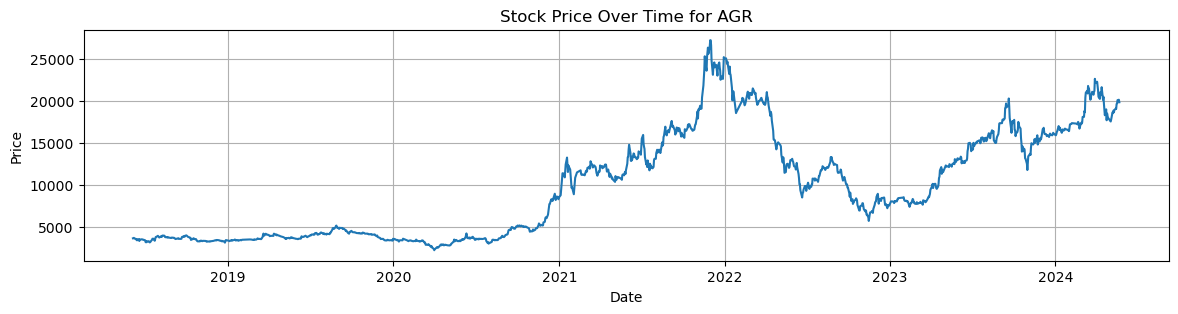

In [10]:
subsquence_plot_price(AGR_df, group_name_0)

Dựa vào biểu đồ trực quan, ta có thể thấy:
- Time series có xu hướng (trend), vì mean thay đổi theo thời gian (vi phạm điều kiện #1).
- Phương sai thay đổi theo thời gian: trước năm 2021 phương sai nhỏ, nhưng sau năm 2021 thì phương sai lớn (vi phạm điều kiện #2).

**Summary Statistics**

In [11]:
def summary_statistics_price(df, df_name):
    if len(df) >= 10:
        # Split data into 10 chunks
        chunks = np.array_split(df['Price'], 10)
        
        # Compare means and variances
        print("{}\t | {}\t\t | {}".format("Chunk", "Mean", "Variance"))
        print("-" * 35)
        for i, chunk in enumerate(chunks, 1):
            print("{:2}\t | {:.5}\t | {:.5}".format(i, np.mean(chunk), np.var(chunk)))
    else:
        print("Not enough data to split into 10 chunks")

In [12]:
summary_statistics_price(AGR_df, group_name_0)

Chunk	 | Mean		 | Variance
-----------------------------------
 1	 | 3476.1	 | 4.8412e+04
 2	 | 3733.1	 | 8.0546e+04
 3	 | 3850.6	 | 3.2726e+05
 4	 | 3553.8	 | 5.5924e+05
 5	 | 9430.1	 | 7.6842e+06
 6	 | 1.6997e+04	 | 1.7443e+07
 7	 | 1.6262e+04	 | 2.4156e+07
 8	 | 8837.7	 | 3.5768e+06
 9	 | 1.3767e+04	 | 9.4157e+06
10	 | 1.7362e+04	 | 5.7454e+06


Dựa vào số liệu thống kê mô tả, ta thấy:
- Mean thay đổi theo thời gian (vi phạm điều kiện #1).
- Variance thay đổi theo thời gian (vi phạm điều kiện #2).

**Histogram Plot**

Nếu histogram gần với phân phối chuẩn thì ta có thể dự đoán mean và variance là không đổi theo thời gian.

In [13]:
def histogram_plot_price(df, df_name):
    plt.figure(figsize=(10, 6))
    plt.hist(df['Price'], bins=10, edgecolor='black')
    plt.title(f'Histogram of Prices for {df_name}')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

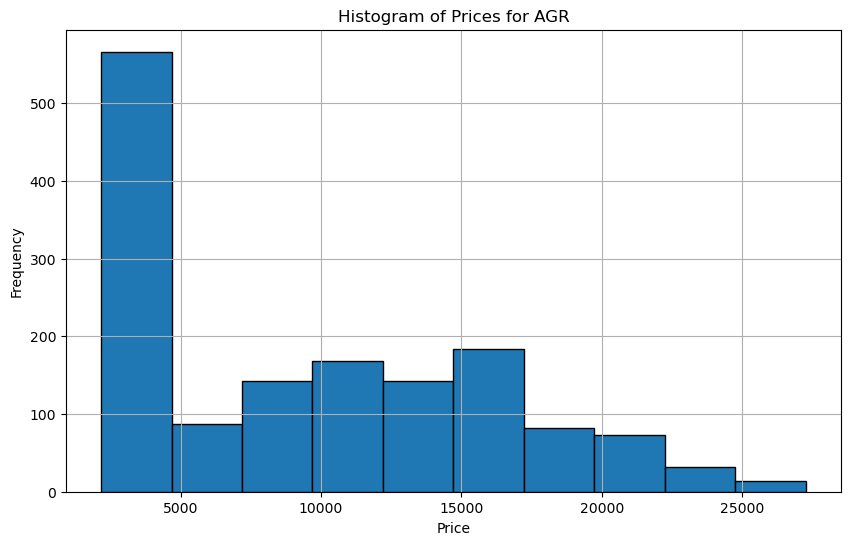

In [14]:
histogram_plot_price(AGR_df, group_name_0)

Chúng ta có thể sử dụng kiểm định thống kê để kiểm tra:

In [15]:
def normal_test_price(df, df_name):
    k2, p = normaltest(df['Price'])

    print(f"Normality test result for {df_name}:")
    # print(f"Statistic: {k2:.4f}")
    # print(f"P-value: {p:.4f}")

    if p < 0.05:
        print("The null hypothesis of normality is rejected.")
        return False
    else:
        print("The null hypothesis of normality cannot be rejected.")
        return True

In [16]:
normal_test_price(AGR_df, group_name_0)

Normality test result for AGR:
The null hypothesis of normality is rejected.


False

Do đó có thể kết luận được rằng time series trên không tuân theo phân phối chuẩn. Do đó, mean và variance của time series thay đổi theo thời gian (vi phạm điều kiện #1 và #2).

**Augmented Dickey-Fuller (ADF) Test**

- **Null hypothesis** $H_0$: the series is non-stationary.
- **Alternative hypothesis** $H_1$: the series is stationary.
> Chú ý: ADF test có thể không chính xác nếu dataset nhỏ hoặc trong trường hợp phương sai thay đổi (heteroskedasticity). Do đó cần kết hợp nhiều phương pháp bên cạnh ADF test.

In [17]:
def adf_test_price(df, df_name):
    adf_result = adfuller(df['Price'])

    adf, pvalue, usedlag, nobs, critical_values, icbest = adf_result

    print(f"ADF test result for {df_name}:")
    # print("ADF Statistic:", adf)
    # print("p-value:", pvalue)
    # print("Used lag:", usedlag)
    # print("Number of observations:", nobs)
    # print("Critical values:", critical_values)
    # print("IC best:", icbest)

    if pvalue < 0.05:
        print("The null hypothesis of non-stationarity is rejected.")
        return False
    else:
        print("The null hypothesis of non-stationarity cannot be rejected.")
        return True

In [18]:
adf_test_price(AGR_df, group_name_0)

ADF test result for AGR:
The null hypothesis of non-stationarity cannot be rejected.


True

Kết quả của ADF test cho thấy ta không thể bác bỏ $H_0$, do đó time series là non-stationary.

**Vậy, time series về giá cổ phiếu `price` của ngân hàng AGRIBANK là non-stationary.**

#### **1.2. Đánh giá tổng quan tất cả các ngân hàng**

**Sub-sequence plots**

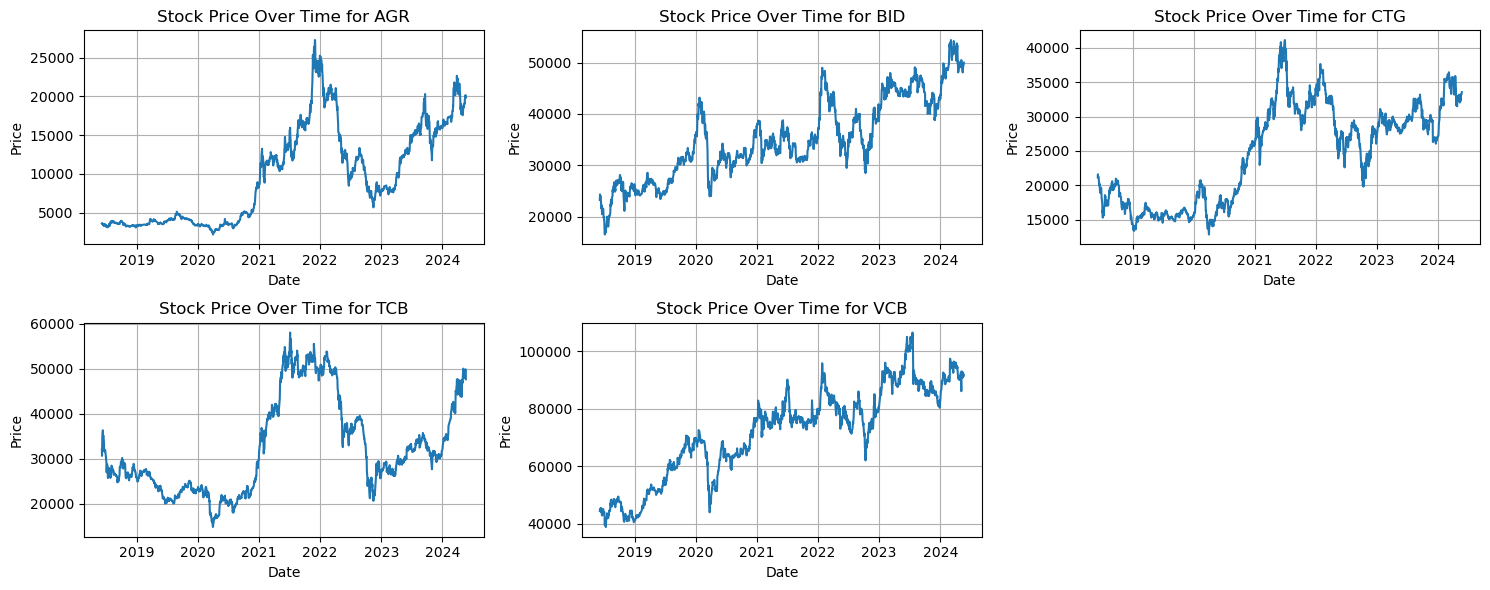

In [19]:
num_plots = len(dataframes)
cols = 3
rows = (num_plots + 1) // cols 

plt.figure(figsize=(15, 3 * rows))

for i, (name, df) in enumerate(dataframes.items(), 1):
    plt.subplot(rows, cols, i)
    plt.plot(df['Date'], df['Price'])
    plt.title(f'Stock Price Over Time for {name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)

plt.tight_layout()  
plt.show()

**Histogram plots**

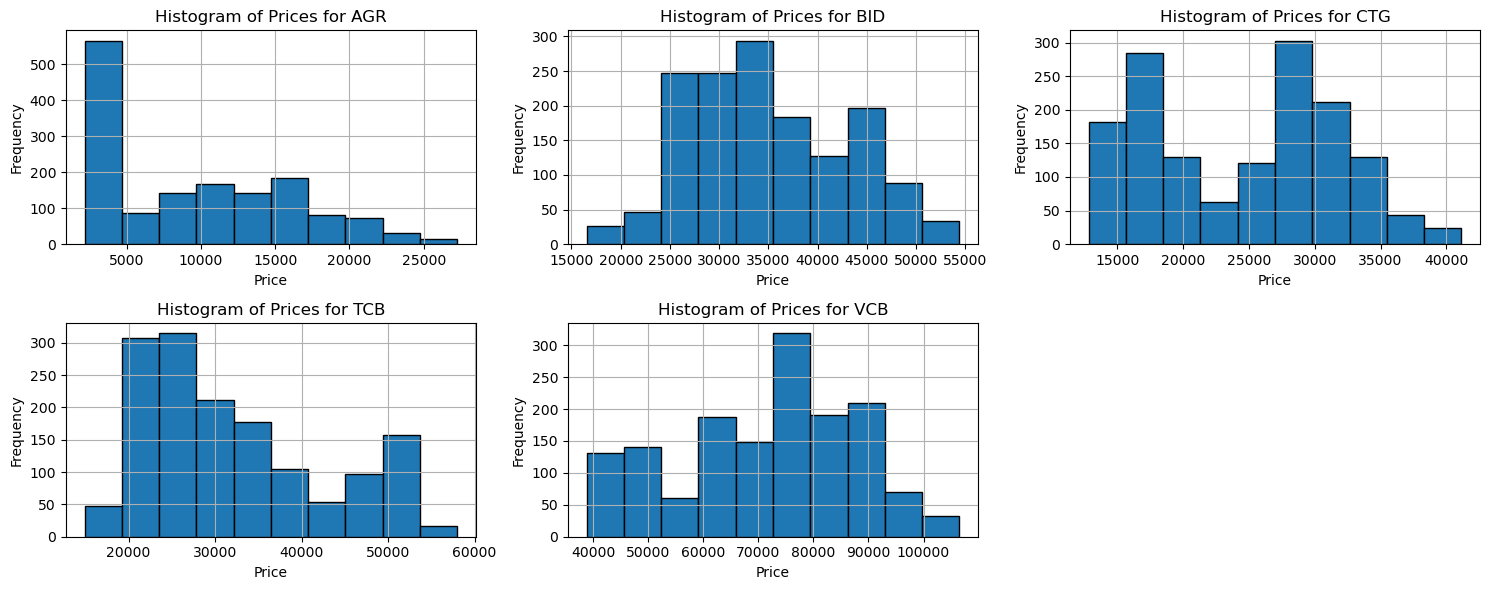

In [20]:
num_plots = len(dataframes)
cols = 3  
rows = (num_plots + 1) // cols 

plt.figure(figsize=(15, 3 * rows))

for i, (name, df) in enumerate(dataframes.items(), 1):
    plt.subplot(rows, cols, i)
    plt.hist(df['Price'], bins=10, edgecolor='black')
    plt.title(f'Histogram of Prices for {name}')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()  
plt.show()

In [21]:
results = []

for df_name, df in dataframes.items():
    print('\n')
    normal_result = normal_test_price(df, df_name)
    adf_result = adf_test_price(df, df_name)
    results.append([df_name, normal_result, adf_result])



Normality test result for AGR:
The null hypothesis of normality is rejected.
ADF test result for AGR:
The null hypothesis of non-stationarity cannot be rejected.


Normality test result for BID:
The null hypothesis of normality is rejected.
ADF test result for BID:
The null hypothesis of non-stationarity cannot be rejected.


Normality test result for CTG:
The null hypothesis of normality is rejected.
ADF test result for CTG:
The null hypothesis of non-stationarity cannot be rejected.


Normality test result for TCB:
The null hypothesis of normality is rejected.
ADF test result for TCB:
The null hypothesis of non-stationarity cannot be rejected.


Normality test result for VCB:
The null hypothesis of normality is rejected.
ADF test result for VCB:
The null hypothesis of non-stationarity cannot be rejected.


In [22]:
results_df = pd.DataFrame(results, columns=['price series', 'normal', 'non-stationary'])
results_df

,price series,normal,non-stationary
0,AGR,False,True
1,BID,False,True
2,CTG,False,True
3,TCB,False,True
4,VCB,False,True


## **2. Prediction**

Ở đây ta sẽ dự đoán giá cổ phiếu cho ngân hàng BIDV (mã BID).

In [23]:
BID_name = 'BID'
BID_df = dataframes[BID_name]
BID_df.tail(5)

,Date,Price,Open,High,Low,Vol.,Change %,XSTC
2975,2024-05-15,48600.0,49000.0,49000.0,48100.0,1390000.0,1.04,BID
2976,2024-05-16,48840.0,49200.0,50300.0,48600.0,2100000.0,0.49,BID
2977,2024-05-17,49350.0,49750.0,50000.0,49200.0,1520000.0,1.04,BID
2978,2024-05-20,49600.0,49450.0,50700.0,49400.0,2190000.0,0.51,BID
2979,2024-05-21,50000.0,49600.0,50300.0,49600.0,493100.0,0.81,BID


Để áp dụng các mô hình ARMA cho mục đích dự đoán, ta cần phải đưa time series từ `non-stationary` về `stationary`. Một số các phương pháp đó là:

| Transformation       | Effect                 |
|----------------------|------------------------|
| Subtract trend       | Constant mean          |
| Apply log            | Constant variance      |
| Differencing         | Remove autocorrelation |
| Seasonal differencing| Remove periodic component|


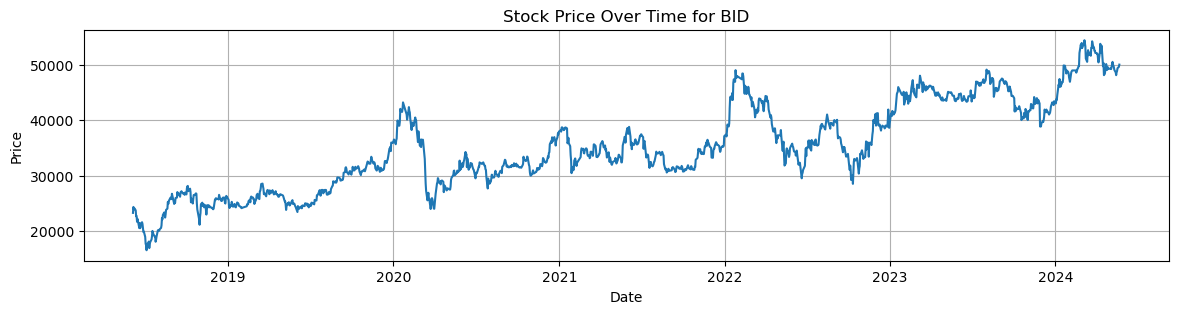

In [24]:
subsquence_plot_price(BID_df, BID_name)

**Subtract estimated trend và seasonality**

In [25]:
from scipy.fft import fft, fftfreq
import numpy as np

# Perform FFT on the price data
price_series = df['Price'].values
n = len(price_series)
price_fft = fft(price_series)
freqs = fftfreq(n)

# Only take the positive half of the frequencies
pos_freqs = freqs[:n // 2]
pos_price_fft = np.abs(price_fft)[:n // 2]

# Find the dominant frequency
dominant_freq = pos_freqs[np.argmax(pos_price_fft[1:]) + 1]  # Ignoring the zero frequency

# Calculate the period
dominant_period = 1 / dominant_freq

print(f'Dominant Frequency: {dominant_freq}')
print(f'Dominant Period: {dominant_period} days')

Dominant Frequency: 0.0006711409395973154
Dominant Period: 1490.0 days


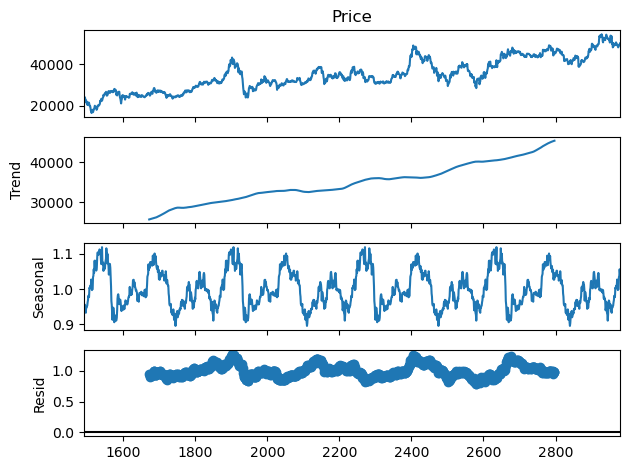

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition on the 'Price' column of BID_df
ss_decomposition = seasonal_decompose(x=BID_df['Price'], model='multiplicative', period=365)

# Plot the decomposition results
ss_decomposition.plot()
plt.show()

In [27]:
def subsequence_plot_price(date_series, price_series, title):
    plt.figure(figsize=(12, 3))
    plt.plot(date_series, price_series)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Log-transformed Price')
    plt.grid(True)
    plt.show()

In [28]:
# Ensure the 'Date' column is in datetime format
BID_df['Date'] = pd.to_datetime(BID_df['Date'])


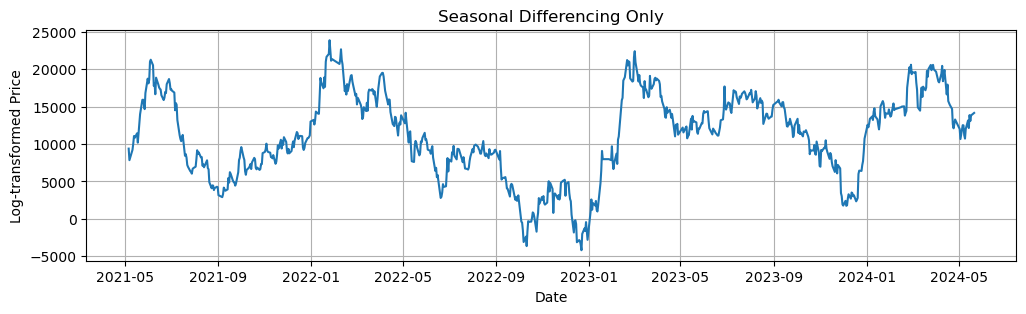

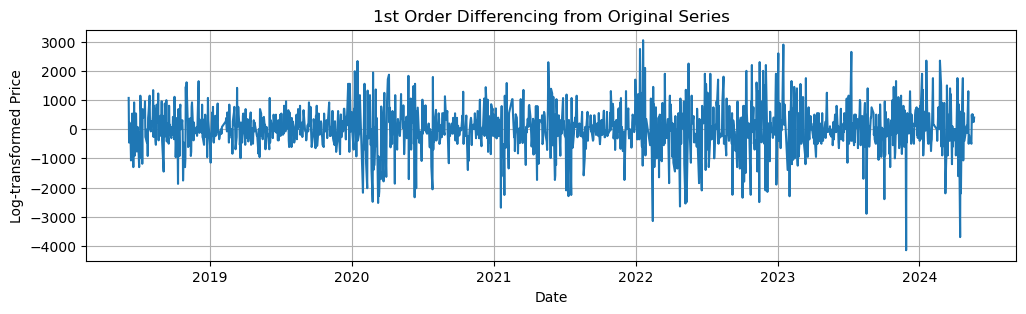

In [88]:
# Remove seasonality (assuming a seasonal period of 12)
seasonal_period = 365*2
price_series = BID_df['Price']
seasonal_diff = price_series.diff(seasonal_period).dropna()

time_values = BID_df['Date']
# Plot the time series after seasonal differencing
time_values_seasonal_diff = BID_df['Date'][seasonal_period:]
time_values_seasonal_diff = time_values_seasonal_diff[:len(seasonal_diff)]
subsequence_plot_price(time_values_seasonal_diff, seasonal_diff, title="Seasonal Differencing Only")

# Original series
price_series = BID_df['Price']

# Remove trend (first-order differencing) from the original series
first_order_diff = price_series.diff().dropna()

# Plot the time series after first-order differencing
time_values_first_order_diff = BID_df['Date'][1:]
time_values_first_order_diff = time_values_first_order_diff[:len(first_order_diff)]
subsequence_plot_price(time_values_first_order_diff, first_order_diff, title="1st Order Differencing from Original Series")

In [53]:
def normal_test_price(series, df_name):
    k2, p = normaltest(series)

    print(f"Normality test result for {df_name}:")
    # print(f"Statistic: {k2:.4f}")
    # print(f"P-value: {p:.4f}")

    if p < 0.05:
        print("The null hypothesis of normality is rejected.")
        return False
    else:
        print("The null hypothesis of normality cannot be rejected.")
        return True

In [83]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")
    
    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid(); 

Normality test result for seasonal differenced series:
The null hypothesis of normality is rejected.
ADF Statistic: -2.62
p-value: 0.090
Critical Values: ['1%: -3.44', '5%: -2.87', '10%: -2.57']



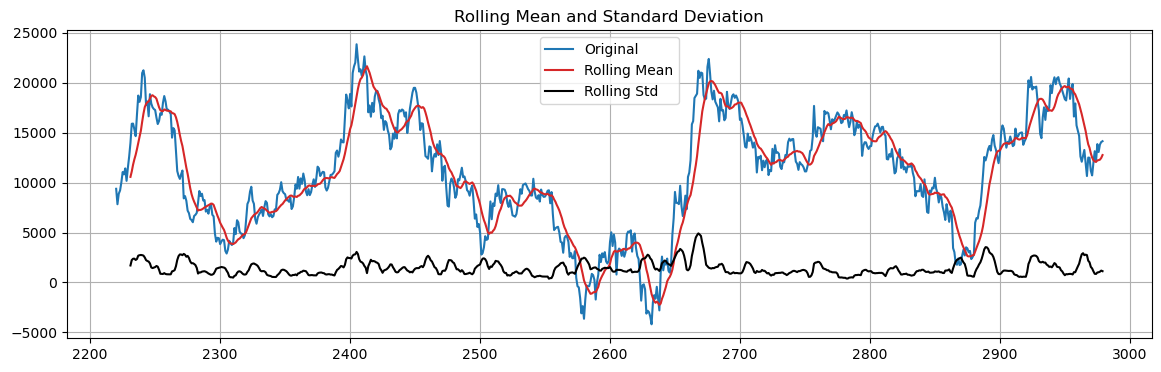

In [85]:
normal_result = normal_test_price(seasonal_diff, 'seasonal differenced series')
adf_result = adftest(seasonal_diff, plots=True)

In [79]:
normal_result = normal_test_price(first_order_diff, 'seasonal differenced series + 1st order')
adf_result = adf_test_price(first_order_diff, 'seasonal differenced series + 1st order')

Normality test result for seasonal differenced series + 1st order:
The null hypothesis of normality is rejected.
ADF test result for seasonal differenced series + 1st order:
The null hypothesis of non-stationarity is rejected.


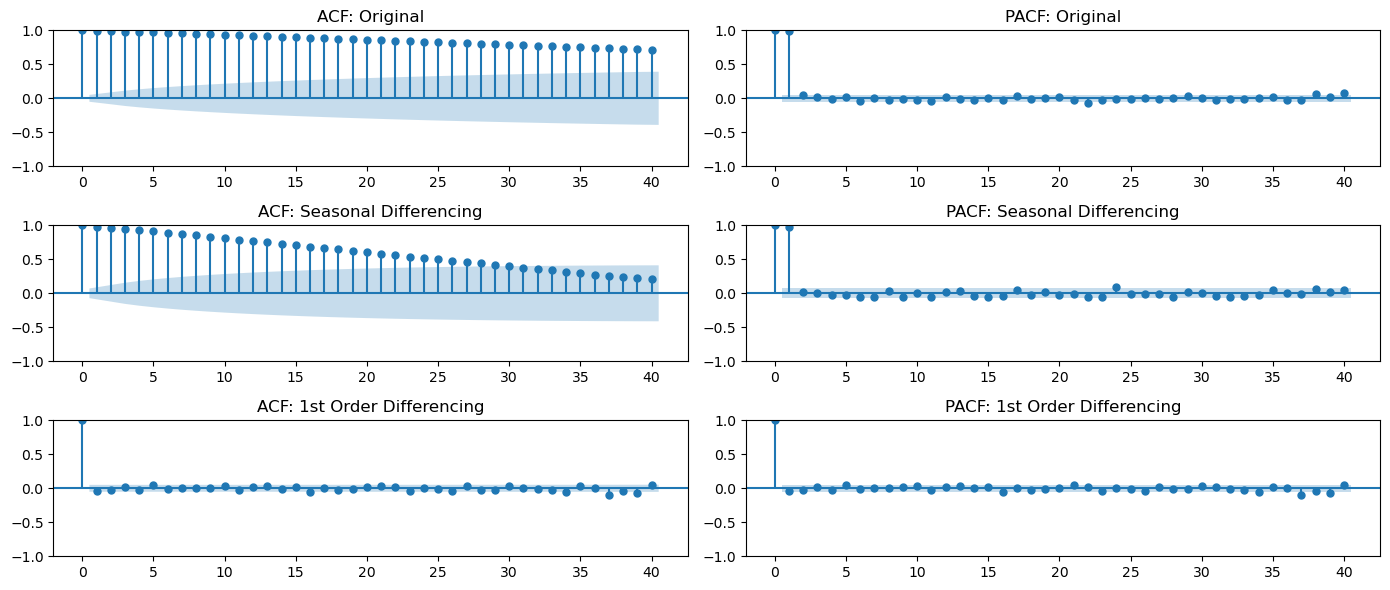

In [80]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for seasonally + first-order differenced data
plt.figure(figsize=(14, 6))

plt.subplot(321)
plot_acf(price_series, lags=40, ax=plt.gca())
plt.title('ACF: Original')

plt.subplot(322)
plot_pacf(price_series, lags=40, ax=plt.gca())
plt.title('PACF: Original')

plt.subplot(323)
plot_acf(seasonal_diff, lags=40, ax=plt.gca())
plt.title('ACF: Seasonal Differencing')

plt.subplot(324)
plot_pacf(seasonal_diff, lags=40, ax=plt.gca())
plt.title('PACF: Seasonal Differencing')

plt.subplot(325)
plot_acf(first_order_diff, lags=40, ax=plt.gca())
plt.title('ACF: 1st Order Differencing')

plt.subplot(326)
plot_pacf(first_order_diff, lags=40, ax=plt.gca())
plt.title('PACF: 1st Order Differencing')

plt.tight_layout()
plt.show()